<a href="https://www.kaggle.com/alexnks/heart-failure-pred-various-models-comparison?scriptVersionId=83139229" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [63]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/heart-failure-prediction/heart.csv


### Hi! My name is Alex and this is my first notebook in order to show you my approach to this problem. As this is my first notebook I will try to state clearly my hypothesis so we can discuss in the comments. I hope you can enjoy it as much as I enjoyed while I was writting this! :D

# Import data


In [64]:
heart = pd.read_csv("/kaggle/input/heart-failure-prediction/heart.csv")

### See the first five rows of the dataset to see if the data has been loaded well

In [65]:
heart.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


### At first sight we can conclude there are 5 categorical data. Which are Sex, ChestPainType, RestingECG, ExerciseAngina and ST_Slope
### Let's see if the target variable is skewed. If so we have to use other techniques such as undersampling or oversampling.

In [66]:
heart["HeartDisease"].value_counts()

1    508
0    410
Name: HeartDisease, dtype: int64

### Due to the fact the results are balanced (nearly 50% each one) we do not need to use those techniques :)

### Let's see info of the columns in order to get some insights of the dataset such as **null entries** or which columns have **categorical data**

In [67]:
heart.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


### At this point we can conclude there are no null entries on the dataset. This doesn't mean that there is not null data because sometimes people can use different values to represent missing data, and Pandas will not recognize that :\ . But not everything is lost! We can use different methods to differentiate those points. Here I would like to start the EDA, and plot different graphs to have a wider view of the dataset

## *Exploratory Data Analysis*

### First let's import Seaborn to make the plots

In [68]:
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)}) #Bigger images

# Correlation matrix

### With the correlation matrix we can see the relationship between the different variables. The number has a range between 1 and -1 and represents if there is a **linear** relationship between two variables. It is important to remember that shows only **linear** relationships becuase a correlation of zero doesn't mean there is no relationship, it just shows there is no **linear** relationship.

### It is important to remember that this matrix is simetric so the info of the upper diagonal is the same as the one in the lower diagonal.

<AxesSubplot:>

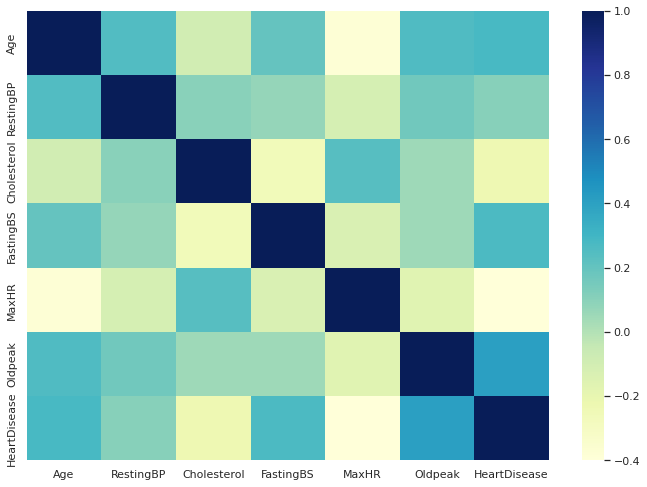

In [69]:
sns.heatmap(heart.corr(),cmap="YlGnBu")

### In order to see the relation between the different variables I will use a pairplot.

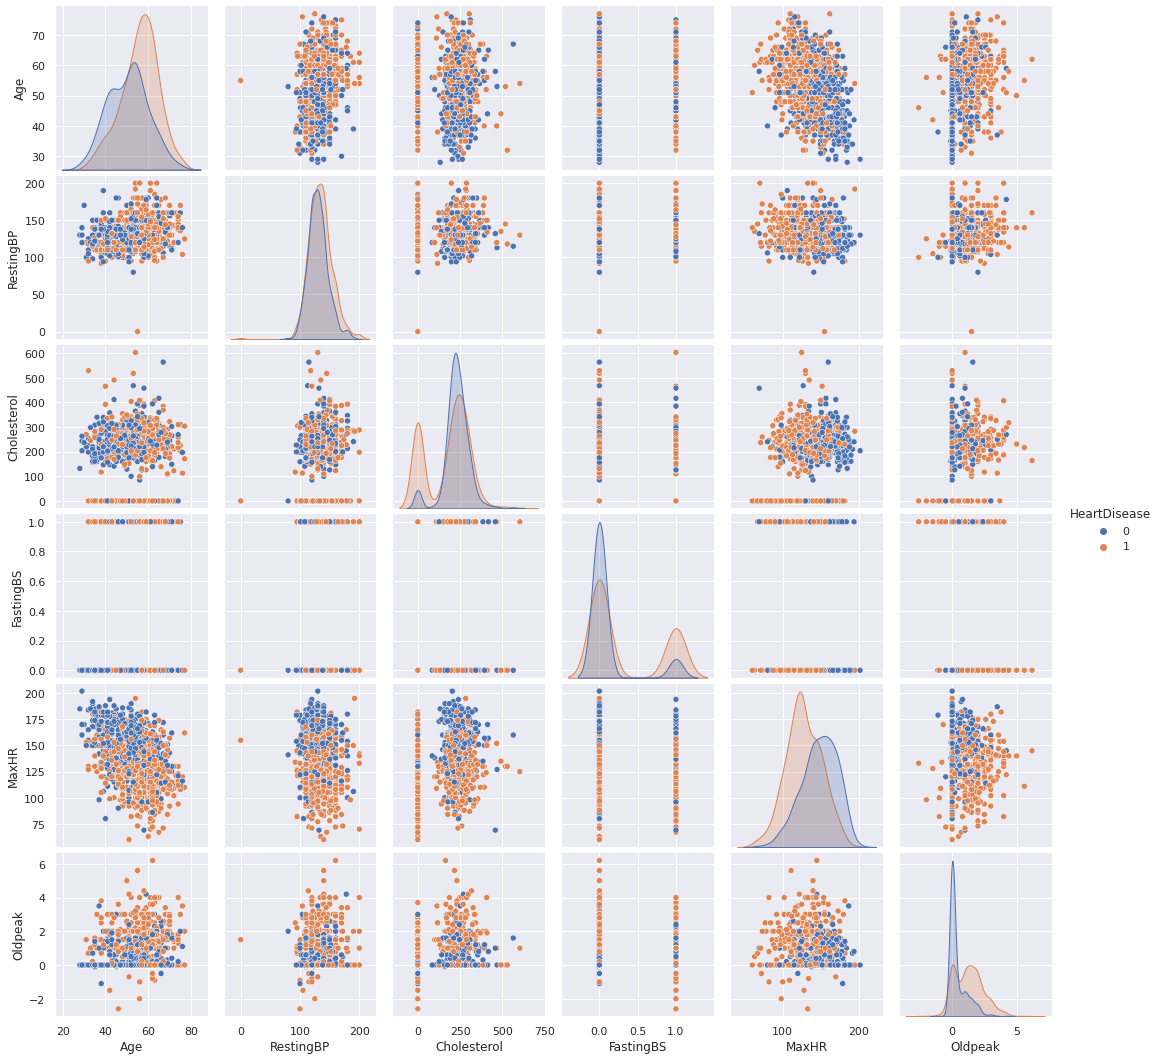

In [70]:
sns.pairplot(heart,hue="HeartDisease")

### With hue we can change the color regarding heart disease. With this plots we can see that oldpeak and restingBP has very long tails. This sometimes can be a symptom of data that has been loaded incorrectly or extreme values used to represent missing data.
### Let's see the box plots to see more clearly the outliers.

## Outliers

### Using boxplots it's easy and fast to see the outliers as it represents those points clearly on the plot.

<AxesSubplot:>

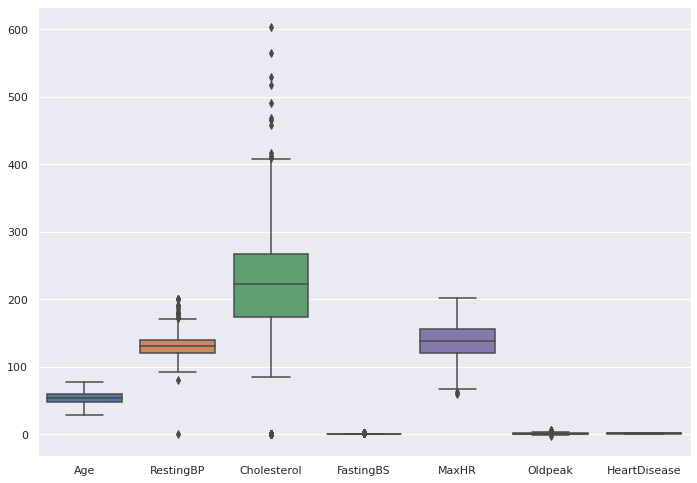

In [71]:
sns.boxplot(data=heart)

### With a quick research we can see some values with RestingBP near zero, which is not possible. Also there are some values with
### Cholesterol near zero which is not possible also. Let's analizy how many of them are and how we can [impute](https://en.wikipedia.org/wiki/Imputation_(statistics)) them.
### Here I will replace the RestingBP equal zero with the median as this is more resistant to outliers that the mean
### Let's search the values with RestingBP equal zero.

<AxesSubplot:ylabel='RestingBP'>

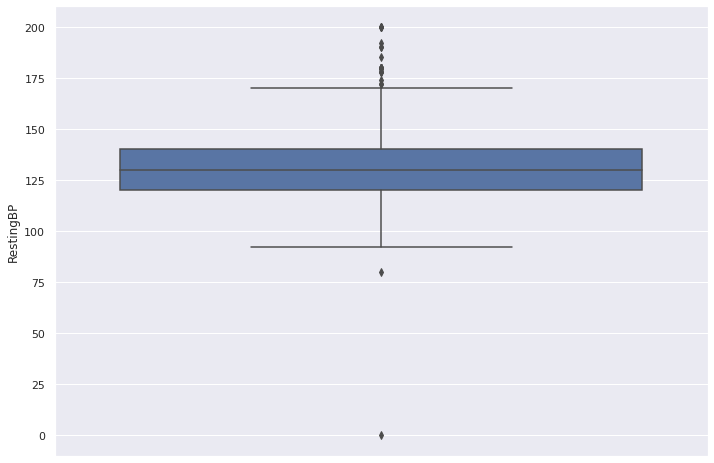

In [72]:
sns.boxplot(y="RestingBP",data=heart)

### Let's search tthe outlier

In [73]:
heart[heart["RestingBP"]<50]

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
449,55,M,NAP,0,0,0,Normal,155,N,1.5,Flat,1


### Here we see the entry do not has RestingBP Cholesterol and FastingBS. I will drop it because it is one entry in one thousand. If 
### we had more data to represent we should use a method to imputate the values.

### Now let's search the values with zero value of Cholesterol.

<AxesSubplot:ylabel='Cholesterol'>

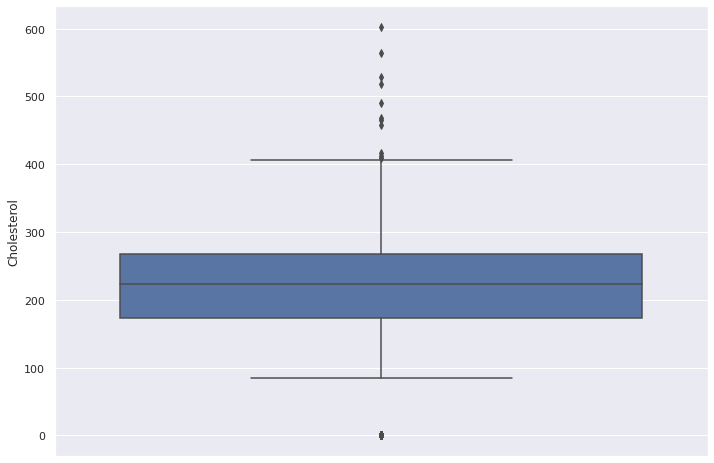

In [74]:
sns.boxplot(y="Cholesterol",data=heart)

In [75]:
heart[heart["Cholesterol"]==0]

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
293,65,M,ASY,115,0,0,Normal,93,Y,0.0,Flat,1
294,32,M,TA,95,0,1,Normal,127,N,0.7,Up,1
295,61,M,ASY,105,0,1,Normal,110,Y,1.5,Up,1
296,50,M,ASY,145,0,1,Normal,139,Y,0.7,Flat,1
297,57,M,ASY,110,0,1,ST,131,Y,1.4,Up,1
...,...,...,...,...,...,...,...,...,...,...,...,...
514,43,M,ASY,122,0,0,Normal,120,N,0.5,Up,1
515,63,M,NAP,130,0,1,ST,160,N,3.0,Flat,0
518,48,M,NAP,102,0,1,ST,110,Y,1.0,Down,1
535,56,M,ASY,130,0,0,LVH,122,Y,1.0,Flat,1


### Almost 10% of the dataset has this value missing. Before making assumptions I will see which is the distribution of HeartDisease within these points. Then I will justify a method to impute the values.

In [76]:
heart[heart["Cholesterol"]==0]["HeartDisease"].value_counts()

1    152
0     20
Name: HeartDisease, dtype: int64

### Here we can see that the 88% of the entries here has a heart disease so this is highly skewed. In order to impute skewed data I will use the median of the values of Cholesterol with heart disease. I will do this because nearly all the entries have heart disease and the median of this values is resistant to outliers.

### This line of code gives me the non zero values of cholesterol with heart disease.

In [77]:
mask = (heart["Cholesterol" ]!= 0) & (heart["HeartDisease"] == 1)
heart.loc[mask]["Cholesterol"].median()

246.0

### I will impute with this value.

In [78]:
heart.loc[heart["Cholesterol"]==0,"Cholesterol"] = heart.loc[mask]["Cholesterol"].median()


### Let's see how the distribution is modified and if the correlation between heart disease and cholesterol has changed

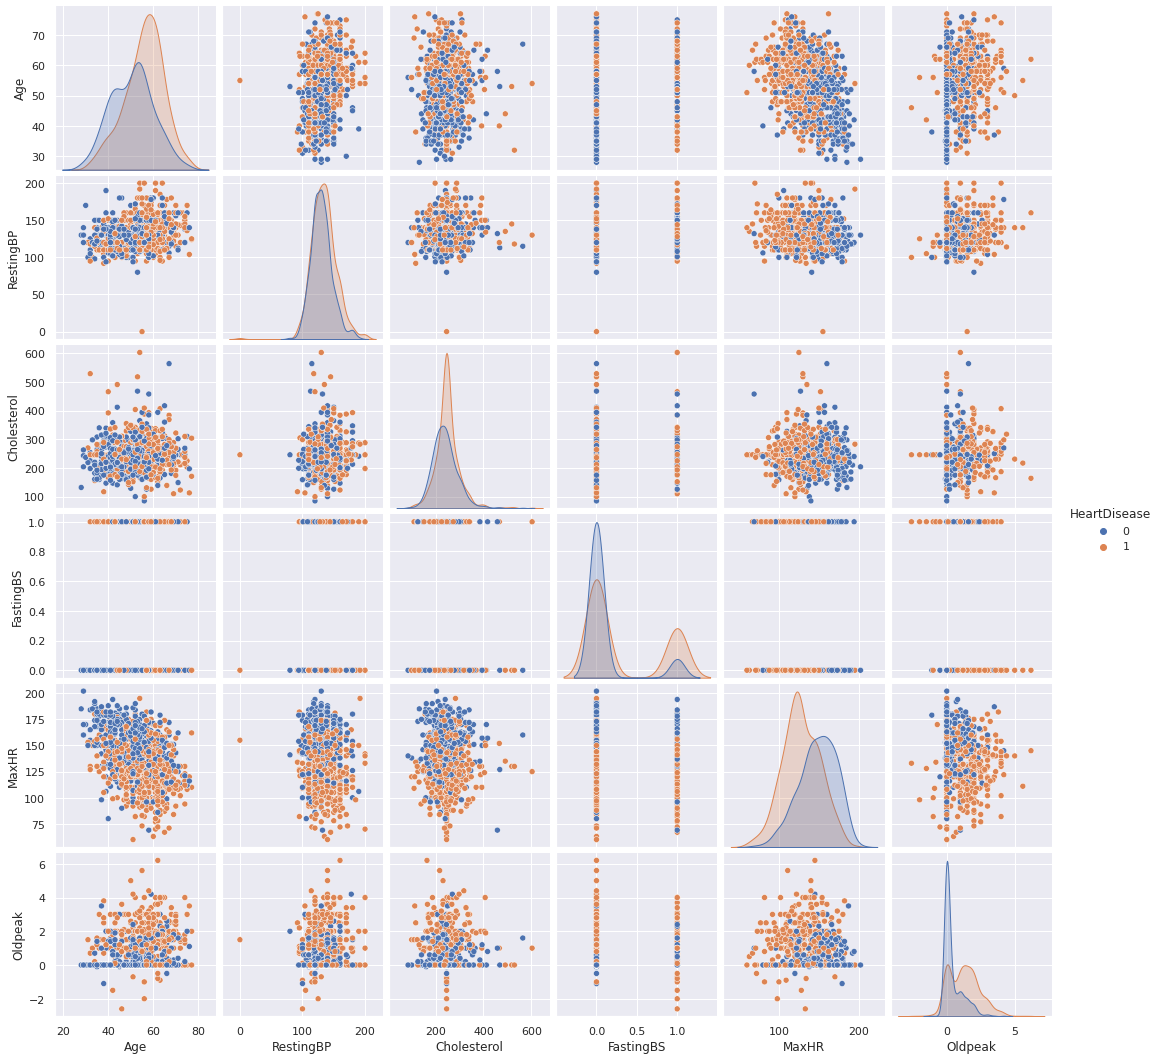

In [79]:
sns.pairplot(data=heart,hue="HeartDisease")

### Here we can see that the distribution of Cholesterol has changed and also the correlation. From having a negative correlation with heart disease now it is positive. This makes sense as this is one of the first estimators a doctor uses to suggest further analysis.

In [80]:
heart.corr()["Cholesterol"]["HeartDisease"]

0.09725462688053992

### Before finishing the EDA I will transform the categorical data into dummy variables. This means that the categorical data such as Sex, that has Male of Female values will be transformed into Sex_M and Sex_F with 0 or 1 with the corresponding entry. This is useful in distance based algorithms because those kind of algorithms needs the data to be normalized. The problem with this is that we are increasing the dimension of the dataset. If we are dealing with heavy datasets after this we should use some PCA to reduce the dimensionality.

### I will get the name of the columns with categorical type.

In [81]:
cat_cols = heart.select_dtypes("object").columns.to_list()
cat_cols

['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']

In [82]:
heart_dummy = pd.get_dummies(heart)

### Let's see how we increased the dimensions of the dataset.

In [83]:
heart_dummy.head()
len(heart_dummy.columns),len(heart.columns)

(21, 12)

# Tree based algorithm
### Let's use the models to compare the scores in our treated data!
### First import the libraries
#### Disclaimer: *Personally I don't like to import everything before starting the notebook because it seems too many information to somebody that is starting like me. I prefer to import as I am going to use in order to see clearly where I will use it.*

In [84]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

### First let's separate the data into X and y.

In [85]:
X = heart_dummy.drop(axis=1,labels="HeartDisease")
y = heart_dummy["HeartDisease"]

### Split the data into train and test.

In [86]:
x_train,x_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=10)

### I will use gridsearch to optimize hyperparameters and prevent overfitting over the training set.

In [87]:
Stimator = DecisionTreeClassifier(criterion="entropy",random_state = 101)
grid = {"max_depth" : [1,2,3,4,5,6,7,8,9]}

In [88]:
gso = GridSearchCV(Stimator,grid,cv=5)

### As we are dealing with tree based algorithms we do not need to normalize the data! So let's train.

In [89]:
gso.fit(x_train,y_train)

GridSearchCV(cv=5,
             estimator=DecisionTreeClassifier(criterion='entropy',
                                              random_state=101),
             param_grid={'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9]})

In [90]:
y_pred = gso.predict(x_test)

### Let's see the score of the model and the confusion matrix

In [91]:
from sklearn.metrics import confusion_matrix,accuracy_score,plot_confusion_matrix

In [92]:
confusion_matrix(y_test,y_pred)

array([[100,  27],
       [ 19, 130]])

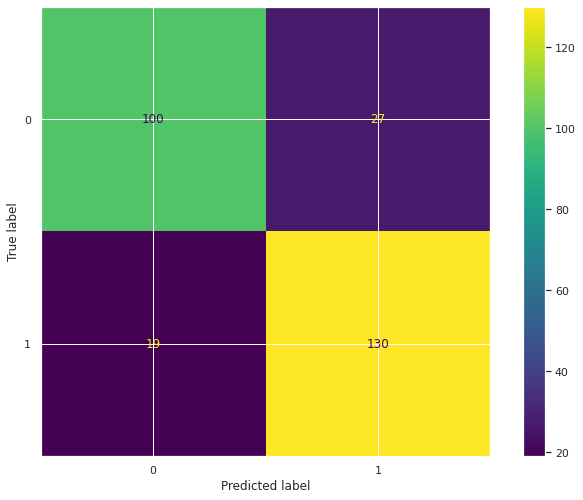

In [93]:
plot_confusion_matrix(gso,x_test,y_test)

In [94]:
accuracy_score(y_test,y_pred)

0.8333333333333334

### Let's see the depth of the tree.

In [95]:
gso.best_params_

{'max_depth': 4}

In [96]:
Stimator_forest = RandomForestClassifier(criterion="entropy")
#To optimize information gain
grid_forest = {"n_estimators" : [1000,2000,3000,4000,5000]}
gso_forest = GridSearchCV(Stimator_forest,grid_forest,cv = 5)

In [97]:
gso_forest.fit(x_train,y_train)
y_predforest = gso_forest.predict(x_test)
accuracy_score(y_test,y_predforest)

0.8333333333333334

In [98]:
gso_forest.best_params_

{'n_estimators': 2000}

### Let's try with a XGBClassifier

In [99]:
Stimator_XGBC = XGBClassifier(use_label_encoder=False,n_estimators=2000)
Stimator_XGBC.fit(x_train,y_train)
y_predXGBC = Stimator_XGBC.predict(x_test)
accuracy_score(y_test,y_predXGBC)

[00:03:46] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.822463768115942

# Distance Based Algorithm
### Let's import the libraries we are going to use

In [100]:
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler


In [101]:
scaler = StandardScaler()
scaled_x_train = scaler.fit_transform(x_train)
scaled_x_test = scaler.transform(x_test)

In [102]:
Stimator_svc = SVC(kernel="rbf")
grid_svc = {"gamma":[0.001,0.01,0.1,1,10],"C":[0.1,1,10,100,1000]}
gso_svc = GridSearchCV(Stimator_svc,grid_svc,cv = 5)

In [103]:
gso_svc.fit(scaled_x_train,y_train)
y_predsvc = gso_svc.predict(scaled_x_test)
accuracy_score(y_test,y_predsvc)


0.855072463768116

In [104]:
Stimator_logreg = LogisticRegression()
grid_logreg = {"C" : [0.1,1,10,100,1000]}
gso_logreg = GridSearchCV(Stimator_logreg,grid_logreg,cv=5)

In [105]:
gso_logreg.fit(scaled_x_train,y_train)
y_predlogreg = gso_logreg.predict(scaled_x_test)
accuracy_score(y_test,y_predlogreg)

0.8405797101449275

# Finished
### To sum up, the model with best accuracy score was SVC. It can be optimized but at this point I will stop here.
### Thanks for reading! Finally, I would like to now how would you had replaced the entries with 0 cholesterol value and. of course, if you liked the post!
# Have a great day!